In [1]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
import matplotlib.pyplot as plt

In [2]:
def _euclidean_distance(X, Y, squared=False):
    XX = np.dot(X,X.T).diagonal()[:, np.newaxis]
    YY = np.dot(Y,Y.T).diagonal()[np.newaxis, :]
    distances = (-2 * np.dot(X,Y.T)) + XX + YY
    np.maximum(distances, 0, out=distances)
    if X is Y:
        np.fill_diagonal(distances, 0)
    return np.sqrt(distances, out=distances) if squared else distances

def _pairwise_kernel(X, Y = None, kernel = 'rbf', d=1):
    if Y is None:
        Y = X
    
    if kernel == 'linear':
        return np.dot(X, Y.T)
    elif kernel == 'rbf':
        dist = _euclidean_distance(X, Y, squared=True)
        # K *= -d
        return np.exp(-dist**2 / (2 * d**2))
        # return (np.exp(dist/(2*(d**2))))
    elif kernel.startswith('poly'):
        return (np.dot(X, Y.T)) ** d
    else:
        raise ValueError('Invalid kernel type.')

In [3]:
def kernel_k_means(clusters, kernel, weights, n_clusters, display=False):
  tolerance = 0.0001
  error = 0
  n = kernel.shape[0]
  center_dists = np.zeros(n)
  iter_num = 1
  
  while True:
    old_error = error
    error = 0
    
    intra_cluster = np.zeros(n_clusters)
    center_dists = np.zeros((n, n_clusters))

    for i in range(n_clusters):

      cluster_points = np.where(clusters == i)[0]
      cluster_weights = weights[cluster_points]

      intra_cluster[i] = np.dot(np.dot(kernel[cluster_points, :][:, cluster_points], 
                                       cluster_weights), cluster_weights)
      # intra_cluster[i] /= np.sum(cluster_weights) ** 2
      intra_cluster[i] /= (np.sum(cluster_weights) ** 2 + 1e-10)

      center_dists[:,i] = np.dot(kernel[:, cluster_points], cluster_weights) 
      # center_dists[:,i] = -2 * center_dists[:,i] / np.sum(cluster_weights) + intra_cluster[i]
      center_dists[:,i] = -2 * center_dists[:,i] / (np.sum(cluster_weights) + 1e-10) + intra_cluster[i]
      center_dists[:,i] += np.diag(kernel)

      center_dists[cluster_points, i] = center_dists[cluster_points, i]
      error += np.dot(cluster_weights, center_dists[cluster_points, i])

    min_dists, clusters = np.min(center_dists, axis=1), np.argmin(center_dists, axis=1)
    
    if display:
      print(f'Iteration {iter_num}: Error = {error}')

    # if iter_num > 1 and abs(1 - (error / old_error)) < tolerance:
    if iter_num > 1 and abs(1 - (error / (old_error + 1e-10))) < tolerance:
      break

    iter_num += 1
      
  return clusters, error, center_dists

def MVKKM(K, n_clusters, n_views, p, init_clusters, init_weights):
  if p < 1:
    raise ValueError('p must be greater than or equal to 1')

  if np.any(init_weights < 0) or abs(np.sum(init_weights) - 1) > 1e-15:
    raise ValueError('Weights must be positive and sum to unity')

  n_points = K.shape[0] // n_views

  trace_per_view = [np.trace(K[i*n_points:(i+1)*n_points, :]) for i in range(n_views)]

  iter_num = 1
  old_error = np.inf

  clusters = init_clusters
  weights = init_weights

  while True:
    print('--------------- MVKKM Iteration {} ---------------'.format(iter_num))

    # Update clusters
    print('Updating clusters...')

    K_combined = np.zeros((n_points, n_points))
    for i in range(n_views):
      K_combined += weights[i]**p * K[i*n_points:(i+1)*n_points, :]

    clusters, error, _ = kernel_k_means(clusters, K_combined, np.ones(n_points), n_clusters) 
    print('Objective after updating clusters:', error)

    if len(np.unique(clusters)) < n_clusters:
      raise ValueError('Empty clusters detected')

    # Y = csr_matrix((n_points, n_clusters))
    Y = lil_matrix((n_points, n_clusters))
    for i in range(n_clusters):
      cluster_points = np.where(clusters == i)[0]
      Y[cluster_points, i] = 1 / np.sqrt(len(cluster_points))

    trace_per_view_new = [np.trace(Y.T @ K[i*n_points:(i+1)*n_points, :] @ Y) for i in range(n_views)]

    trace_diff = np.array([a - b for a, b in zip(trace_per_view, trace_per_view_new)])

    if abs(1 - (error / old_error)) < 0.0001:
      print('MVKKM reached convergence')
      break

    old_error = error

    # Update weights 
    print('Updating weights...')

    if p != 1:
      weights = 1 / np.power(trace_diff, 1/(p-1))
      weights /= np.sum(weights)
    else:
      min_idx = np.argmin(trace_diff)
      weights = np.zeros(n_views)
      weights[min_idx] = 1

    weights[weights < 1e-5] = 0 
    weights /= np.sum(weights)

    print('Objective after updating weights:', (weights**p) @ trace_diff)
    print()

    iter_num += 1

  return clusters, weights, error

In [3]:
def global_kernel_k_means(kernel, weights, n_clusters, display=False):
  n = kernel.shape[0]
  
  best_errors = np.inf * np.ones(n_clusters)
  best_clusters = np.ones((n, n_clusters))

  # Find 1 cluster solution
  best_clusters[:,0], best_errors[0], _ = kernel_k_means(best_clusters[:,0], kernel, weights, 1, display)

  for m in range(2, n_clusters+1):

    for i in range(n):
    
      clusters = best_clusters[:,m-1].copy()
      clusters[i] = m
      
      if display:
        print(f"\nSearching for {m} clusters. Placing {m}th cluster at point {i} initially.")

      clusters, error, _ = kernel_k_means(clusters, kernel, weights, m, display)

      if display:
        print(f"Final error: {error}")

      if best_errors[m-1] > error:
        best_errors[m-1] = error
        best_clusters[:,m-1] = clusters

  if np.unique(best_clusters[:,m-1]).size < m:
    raise ValueError(f"Could not find more than {m-1} clusters")

  best_idx = np.argmin(best_errors)
  clusters = best_clusters[:, best_idx]
  error = best_errors[best_idx]

  if display:
    print(f"\nBest solution: {best_idx+1} clusters with error {error}")

  return clusters, error

In [4]:
def global_kernel_k_means2(K, Dataset_Weights, Total_clusters, Display=None):
    # Use numpy vectorization 
    Data_num = K.shape[0]
    Best_error = np.inf * np.ones(Total_clusters)
    Best_clusters = np.arange(1, Total_clusters+1)
    
    # Vectorize the search over clusters
    for m in range(2, Total_clusters+1):
        Cluster_errors = []
        for n in range(Data_num):
            Cluster_elem = Best_clusters[:,m-1].copy()
            # Cluster_elem = np.concatenate([Best_clusters[:m-1], [m]])
            Cluster_elem[n] = m
            _, Cluster_error, _ = kernel_k_means(Cluster_elem, K, Dataset_Weights, m, Display)
            Cluster_errors.append(Cluster_error)
        Best_error[m-1] = min(Cluster_errors)
        Best_clusters[m-1] = np.argmin(Cluster_errors) + 1
    
    # Use numpy min instead of looping
    Clustering_error = Best_error.min()
    Clusters = Best_error.argmin()
    Cluster_elem = Best_clusters[Clusters]
    
    # Rest is the same
    if Display == 'details' or Display == 'nutshell':
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++')
        print(f'Best fit:{Clusters} clusters with Clustering Error={Clustering_error}')
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++')
        
    return Cluster_elem, Clustering_error

In [5]:
import numpy as np

def fast_global_kernel_k_means(K, dataset_weights, total_clusters, display=False):
    # Dataset size
    data_num = K.shape[0]
    
    # Store optimal clustering error for 1,2,...,total_clusters clusters
    best_error = np.zeros(total_clusters)
    
    # Store cluster assignments for optimal 1,2,...,total_clusters clusters 
    best_clusters = np.ones((data_num, total_clusters), dtype=int)
    
    # Find 1 cluster solution
    best_clusters[:,0], best_error[0], center_dist = kernel_k_means(best_clusters[:,0], K, dataset_weights, 1, display)
    
    # Find 2,...,total_clusters solutions
    for m in range(2, total_clusters):
        max_reduction = -1
        
        # Place m-th cluster at point n, calculate guaranteed error reduction
        for n in range(data_num):
            reduction = center_dist - (K[n,n] + np.diag(K) - 2*K[n,:])
            reduction[reduction < 0] = 0
            total_reduction = np.dot(dataset_weights, reduction)

            if (total_reduction > max_reduction).all():
                max_reduction = total_reduction
                index = n
        
        # Initialize m-th cluster at point with max error reduction
        cluster_elem = best_clusters[:,m-1].copy() 
        cluster_elem[index] = m
        
        if display == 'details' or display == 'nutshell':
            print('\n\nSearching for {} clusters. Initially placing {}th cluster at point {}'.format(m, m, index))
            
        # Find m cluster solution 
        best_clusters[:,m], best_error[m], center_dist = kernel_k_means(cluster_elem, K, dataset_weights, m, display)
        center_dist = center_dist[:,m-1]
        
        if display == 'details' or display == 'nutshell':
            print('Final Clustering error={}'.format(best_error[m]))
            
        if len(np.unique(best_clusters[:,m])) < m:
            raise Exception('Not able to find more than {} clusters'.format(m-1))
            
    # Solution with lowest error is best
    min_error_idx = np.argmin(best_error)
    clustering_error = best_error[min_error_idx]
    cluster_elem = best_clusters[:, min_error_idx]
    
    if display == 'details' or display == 'nutshell':
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++')
        print('Best fit: {} clusters with Clustering Error={}'.format(min_error_idx+1, clustering_error))
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++')
        
    return cluster_elem, clustering_error

Global Kernel K-Means initialization
End initialization

--------------- MVKKM Iteration 1 ---------------
Updating clusters...
Objective after updating clusters: 304.4001791860114
Updating weights...
Objective after updating weights: 295.9208561345807

--------------- MVKKM Iteration 2 ---------------
Updating clusters...
Objective after updating clusters: 292.9784575829066
Updating weights...
Objective after updating weights: 292.1081716883581

--------------- MVKKM Iteration 3 ---------------
Updating clusters...
Objective after updating clusters: 290.6438384592775
Updating weights...
Objective after updating weights: 290.5027987205148

--------------- MVKKM Iteration 4 ---------------
Updating clusters...
Objective after updating clusters: 290.50279872073725
Updating weights...
Objective after updating weights: 290.5027987205148

--------------- MVKKM Iteration 5 ---------------
Updating clusters...
Objective after updating clusters: 290.50279872073725
MVKKM reached convergence


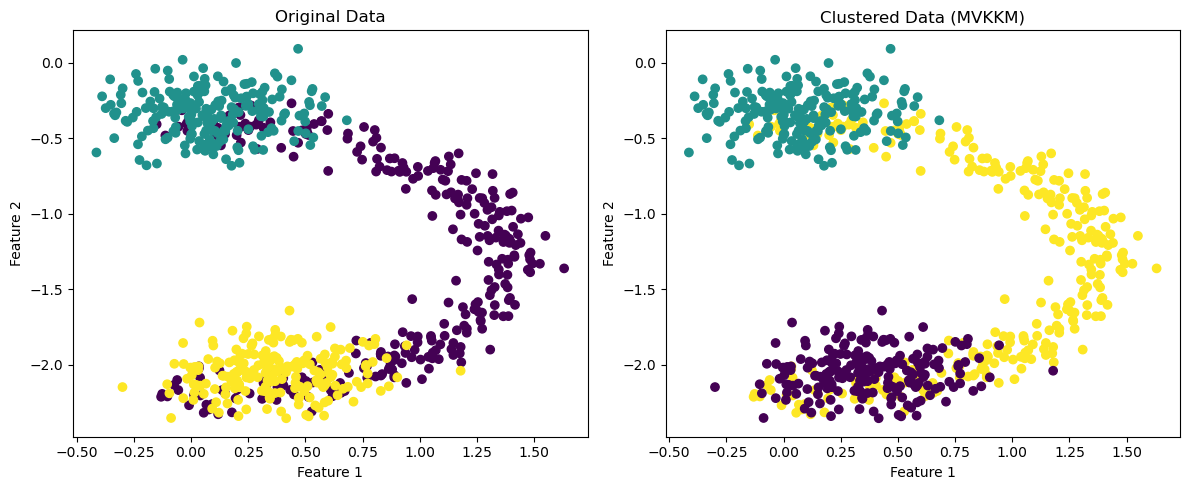

In [8]:
import numpy as np
from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import rbf_kernel
import scipy.io

n_clusters = 3
data = scipy.io.loadmat('datasets/synthetic_data.mat')

X1 = data["View_1"]
X2 = data["View_2"]
X = [X1, X2]
y = data["Ground_truth"].flatten()

# K = np.array(scipy.io.loadmat('datasets/synthetic_data_kernel.mat')['K'])
K = np.vstack([_pairwise_kernel(X1, kernel="rbf", d=0.2), _pairwise_kernel(X2, kernel="rbf", d=0.2)])

# Run MVKKM
n_views = 2
p = 1.5
init_weights = np.full(n_views, 1/n_views)

n_points = K.shape[0] // n_views
# Compute composite kernel 
K_combined = np.zeros((n_points, n_points))
for i in range(n_views):
  start = i * n_points
  end = (i+1) * n_points
  K_combined += init_weights[i]**p * K[start:end, :]
# Initialize with Global K-Means
print('Global Kernel K-Means initialization')
# init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
init_clusters = np.random.randint(0, n_clusters, n_points)
print('End initialization\n')

cluster_labels, weights, error = MVKKM(K, n_clusters, n_views, p, init_clusters, init_weights)

# Plot the original data and the clustered data
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X2[:, 0], X2[:, 1], c=y, cmap='viridis')
plt.title('Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(X2[:, 0], X2[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clustered Data (MVKKM)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import normalized_mutual_info_score

# Calculate NMI
nmi_score = normalized_mutual_info_score(cluster_labels, y)
print("Normalized Mutual Information (NMI):", np.round(nmi_score * 100, 2), "%")

Normalized Mutual Information (NMI): 100.0 %


In [24]:
import pandas as pd

# V1 = pd.read_csv('datasets/HW/mfeat-fou', header=None, delimiter="\\s+").to_numpy(dtype=np.float64)
# V2 = pd.read_csv('datasets/HW/mfeat-fac', header=None, delimiter="\\s+").to_numpy(dtype=np.float64)
# V3 = pd.read_csv('datasets/HW/mfeat-kar', header=None, delimiter="\\s+").to_numpy(dtype=np.float64)
# V4 = pd.read_csv('datasets/HW/mfeat-pix', header=None, delimiter="\\s+").to_numpy(dtype=np.float64)
# X = [V1, V2, V3, V4]
# y = np.vstack([np.full(200, i) for i in range(10)]).flatten()

data = scipy.io.loadmat('datasets/handwritten.mat')
X_ = data['X'].flatten()
X = [X_[0].astype(np.float64), X_[1].astype(np.float64), X_[2].astype(np.float64), X_[3].astype(np.float64)]
y = data['Y'].flatten()

n_clusters = 10
K = np.vstack([_pairwise_kernel(v, kernel="poly", d=0.7)/np.mean(_pairwise_kernel(v, kernel="poly", d=0.7)) for v in X])

# Run CWK2M
n_views = len(X)
p = (10**0.8)
init_weights = np.full(n_views, 1/n_views)

n_points = K.shape[0] // n_views
# Compute composite kernel 
K_combined = np.zeros((n_points, n_points))
for i in range(n_views):
  start = i * n_points
  end = (i+1) * n_points
  K_combined += init_weights[i]**p * K[start:end, :]
# Initialize with Global K-Means
print('Global Kernel K-Means initialization')
# init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
init_clusters = np.random.randint(0, n_clusters, n_points)
print('End initialization\n')

cluster_labels, weights, error = MVKKM(K, n_clusters, n_views, p, init_clusters, init_weights)

Global Kernel K-Means initialization
End initialization

--------------- MVKKM Iteration 1 ---------------
Updating clusters...
Objective after updating clusters: 0.12490512558973044
Updating weights...
Objective after updating weights: 0.055965278871447234

--------------- MVKKM Iteration 2 ---------------
Updating clusters...
Objective after updating clusters: 0.054646464093758285
Updating weights...
Objective after updating weights: 0.054581586489733144

--------------- MVKKM Iteration 3 ---------------
Updating clusters...
Objective after updating clusters: 0.05457775400333067
Updating weights...
Objective after updating weights: 0.05457728926219098

--------------- MVKKM Iteration 4 ---------------
Updating clusters...
Objective after updating clusters: 0.05457728926624514
MVKKM reached convergence


In [25]:
# Calculate NMI
nmi_score = normalized_mutual_info_score(cluster_labels, y)
print("Normalized Mutual Information (NMI):", np.round(nmi_score * 100, 2), "%")

Normalized Mutual Information (NMI): 74.25 %


In [93]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(cluster_labels, y.flatten())
print(accuracy)

0.094


In [94]:
accuracy = 0
for i in range(10):
    lbls = cluster_labels[200*i:200*i+200]
    # print(200*i, 200*i+200)
    # print(np.max(np.bincount((lbls))), np.argmax(np.bincount((lbls))))
    acc = (np.max(np.bincount((lbls))) * 100/200)
    accuracy = accuracy + acc 
    print(f'{i}: {acc}%')

print(accuracy/10)

0: 97.5%
1: 49.0%
2: 57.0%
3: 89.5%
4: 70.5%
5: 96.0%
6: 47.5%
7: 63.5%
8: 92.5%
9: 43.0%
70.6


(2000, 2)


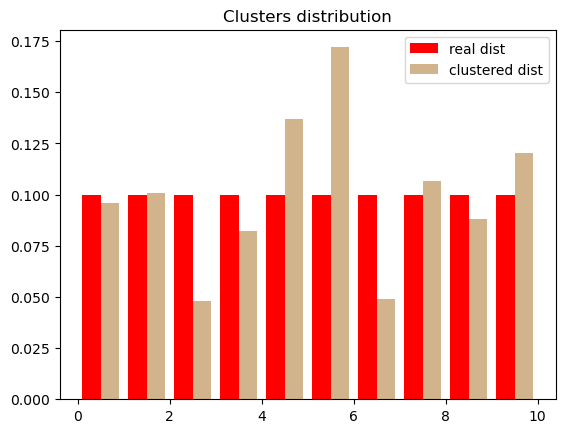

In [89]:
x = np.array([y.flatten(), cluster_labels]).T
print(x.shape)
n_bins = 10
colors = ['red', 'tan']
bar_lbls = ['real dist', 'clustered dist']
bins = np.arange(0, 11)
_ = plt.hist(x, bins, density=True, histtype='bar', color=colors, label=bar_lbls)  # arguments are passed to np.histogram
plt.title("Clusters distribution")
plt.legend(prop={'size': 10})
plt.show()

### Caltech101-7

In [112]:
data = scipy.io.loadmat('datasets/Caltech101-7.mat')
X_ = data['X'].flatten()
X = [X_[0].astype(np.float64), X_[1].astype(np.float64), X_[2].astype(np.float64), X_[3].astype(np.float64)]
y = data['Y'].flatten()

n_clusters = len(np.unique(y))
K = np.vstack([_pairwise_kernel(v, kernel="poly", d=0.5)/np.mean(_pairwise_kernel(v, kernel="poly", d=0.5)) for v in X])

# Run CWK2M
n_views = len(X)
n_points = K.shape[0] // n_views
p = (10**0.8)
init_weights = np.full(n_views, 1/n_views)
init_clusters = np.random.randint(0, n_clusters, n_points)

# Compute composite kernel 
K_combined = np.zeros((n_points, n_points))
for i in range(n_views):
  start = i * n_points
  end = (i+1) * n_points
  K_combined += init_weights[i]**p * K[start:end, :]

# best=0
# for i in range(50):
#   # Initialize with Global K-Means
#   print('Global Kernel K-Means initialization')
#   # init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
#   init_clusters = np.random.randint(0, n_clusters, n_points)
#   # init_clusters = np.load('multi_features_init.npy')
#   print('End initialization\n')

#   cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)
#   nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())

#   if(nmi_score>best):
#     best=nmi_score
#     np.save('caltech101_init.npy', init_clusters)


# Initialize with Global K-Means
print('Global Kernel K-Means initialization')
# init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
print('End initialization\n')
# init_clusters = np.load('caltech101_init.npy')
init_clusters = np.random.randint(0, n_clusters, n_points)

cluster_labels, weights, error = MVKKM(K, n_clusters, n_views, p, init_clusters, init_weights)

Global Kernel K-Means initialization
End initialization

--------------- MVKKM Iteration 1 ---------------
Updating clusters...
Objective after updating clusters: 0.062278099663333815
Updating weights...
Objective after updating weights: 0.05123362684592633

--------------- MVKKM Iteration 2 ---------------
Updating clusters...
Objective after updating clusters: 0.05026637900832466
Updating weights...
Objective after updating weights: 0.05017173986211932

--------------- MVKKM Iteration 3 ---------------
Updating clusters...
Objective after updating clusters: 0.050155309580718704
Updating weights...
Objective after updating weights: 0.05015062571615718

--------------- MVKKM Iteration 4 ---------------
Updating clusters...
Objective after updating clusters: 0.050148243903639395
Updating weights...
Objective after updating weights: 0.050146112507869184

--------------- MVKKM Iteration 5 ---------------
Updating clusters...
Objective after updating clusters: 0.05014481873978109
MVKKM rea

In [115]:
# Calculate NMI
nmi_score = normalized_mutual_info_score(cluster_labels, y.flatten())
print("Normalized Mutual Information (NMI):", np.round(nmi_score * 100, 2), "%")

Normalized Mutual Information (NMI): 44.27 %


## Others

In [40]:
import numpy as np

def Weighted_Kernel_K_Means(Cluster_elem, K, Dataset_Weights, Clusters, Display):
    # Function Inputs:
    # Cluster_elem is an initial partitioning of the dataset.
    # K is the kernel matrix of the dataset.
    # Dataset_Weights is a column vector containing the weight of each datapoint.
    # Clusters is the number of clusters.
    # Display when set to 'details' prints information after each iteration.

    # Function Outputs:
    # Cluster_elem is a column vector containing the final partitioning of the dataset.
    # Clustering_error is the value of the Kernel K-Means objective function corresponding to the final partitioning.
    # Center_dist is a column vector containing the distance of each point to its cluster center.

    # Converge if clustering error difference is less than e.
    e = 0.0001

    # Store the objective function value.
    Clustering_error = 0

    # Dataset size.
    Data_num = len(K)

    # Store the distance between points and their cluster center.
    Center_dist = np.zeros(Data_num)

    Iter = 1

    while True:
        # Keep the clustering error of the previous iteration.
        Old_clustering_error = Clustering_error
        Clustering_error = 0

        Intra = np.zeros(Clusters)
        Cluster_dist = np.zeros((Data_num, Clusters))

        for i in range(1, Clusters + 1):
            # Find the dataset points that belong to cluster i and their weights.
            This_elem = np.where(Cluster_elem == i)[0]
            Dataset_Weights_This_elem = Dataset_Weights[This_elem]

            # Calculate intra-cluster pairwise quantity for cluster i.
            Intra[i-1] = np.dot(np.dot(K[This_elem][:, This_elem], Dataset_Weights_This_elem), Dataset_Weights_This_elem) / np.sum(Dataset_Weights_This_elem)**2

            # Calculate point-cluster quantity between all points and cluster i.
            Cluster_dist[:, i-1] = np.dot(K[:, This_elem], Dataset_Weights_This_elem)

            # Calculate the distance of all points to the center of cluster i.
            Cluster_dist[:, i-1] = (-2 * Cluster_dist[:, i-1] / np.sum(Dataset_Weights_This_elem)) + Intra[i-1] + np.diag(K)

            # Store the distance of cluster's i points to their cluster center.
            Center_dist[This_elem] = Cluster_dist[This_elem, i-1]

            # Add the contribution of cluster i to the clustering error.
            Clustering_error += np.dot(Dataset_Weights_This_elem, Cluster_dist[This_elem, i-1])

        # Update the assignment of points to clusters by placing each point to the closest center.
        Update_cluster_elem = np.argmin(Cluster_dist, axis=1)

        if Display == 'details':
            print(f'\nKernel K-Means Iteration {Iter}')
            print(f'Clustering error={Clustering_error}')

        # Check for convergence.
        if Iter > 1:
            if abs(Old_clustering_error - 0) < 1e-10 or abs(1 - (Clustering_error / Old_clustering_error)) < e:
                break

        Cluster_elem = Update_cluster_elem

        # Drop empty clusters.
        count = 0
        for i in range(1, Clusters + 1):
            if np.size(np.where(Update_cluster_elem == i)) == 0:
                tmp = np.where(Update_cluster_elem > i)[0]
                Cluster_elem[tmp] = Cluster_elem[tmp] - 1
                count += 1
                print('Dropping empty cluster')
        # Reduce the number of clusters if some were dropped.
        Clusters = Clusters - count

        Iter += 1

    return Cluster_elem, Clustering_error, Center_dist


In [41]:
import numpy as np

def MVKKM2(K, Clusters, View_num, p, Init_cluster_elem, Init_w):
    # Function Inputs:
    # K is a matrix containing the views' (positive-definite) kernel matrices.
    # Clusters is the number of clusters we search for.
    # View_num is the number of views present in the dataset.
    # p is the exponent that controls the sparsity of the kernel (view) weights.
    # Init_cluster_elem is an initial partitioning of the dataset.
    # Init_w is a row vector containing initial values for the kernel (view) weights.
    
    # Function Outputs:
    # Cluster_elem is a column vector containing the final partitioning of the dataset.
    # w is a row vector containing the final kernel (view) weights.
    # Clustering_error is the value of the MVKKM objective function (intra-cluster variance).
    
    if p < 1:
        raise ValueError('p must be greater or equal to 1')

    if np.sum(Init_w < 0) != 0 or not np.isclose(np.sum(Init_w), 1):
        raise ValueError('Weights must be positive and sum to unity')

    # Number of points in each view.
    View_data_num = len(K) // View_num

    # Store the trace values tr(K_v) for each kernel K_v which are fixed and do not change.
    Trace_per_kernel_1 = np.zeros(View_num)
    for i in range(View_num):
        Trace_per_kernel_1[i] = np.trace(K[i*View_data_num:(i+1)*View_data_num, :])

    # Start iterations.
    Iter = 1
    Old_Clustering_error = float('inf')
    Cluster_elem = Init_cluster_elem
    w = Init_w

    while True:
        print(f'+++++++++MVKKM Iteration {Iter}+++++++++\n\n')

        # 1st part - Update the clusters for given weights.
        print('Updating the clusters\n')

        # Calculate the composite kernel (see (4) in the paper).
        K_sum = np.zeros((View_data_num, View_data_num))
        for i in range(View_num):
            K_sum += w[i] ** p * K[i * View_data_num:(i + 1) * View_data_num, :]

        # Run kernel k-means to get new assignments.
        # Kernel k-means is initialized using the partitioning returned by the previous iteration.
        # Cluster_elem contains the new assignments.
        # Clustering_error is the objective (intra-cluster variance) value after updating the clusters.
        [Cluster_elem, Clustering_error, Center_dist] = Weighted_Kernel_K_Means(Cluster_elem, K_sum, np.ones(View_data_num), Clusters, '-')
        # Implement the Weighted_Kernel_K_Means function separately as it is not provided here.

        print(f'The objective after updating the clusters is: {Clustering_error}\n')

        if len(np.unique(Cluster_elem)) < Clusters:
            raise ValueError('Empty clusters detected')

        # Calculate the cluster indicator matrix Y (see (3) in the paper).
        Y = np.zeros((View_data_num, Clusters))
        for i in range(Clusters):
            Points_cluster_i = np.where(Cluster_elem == i+1)[0]
            Y[Points_cluster_i, i] = 1 / np.sqrt(len(Points_cluster_i))

        # Store the new trace values tr(Y' K_v Y) for each kernel K_v after the kernel k-means run.
        Trace_per_kernel = np.zeros(View_num)
        for i in range(View_num):
            Trace_per_kernel[i] = np.trace(Y.T @ K[i * View_data_num:(i + 1) * View_data_num, :] @ Y)

        # Store the per-view trace differences.
        # These are the per-view intra-cluster variances after updating the clusters (D_v quantity in the paper).
        Trace_per_kernel_diff = Trace_per_kernel_1 - Trace_per_kernel

        # Check for convergence.
        if np.abs(1 - (Clustering_error / Old_Clustering_error)) < 0.0001:
            print('MVKKM reached convergence\n')
            break

        Old_Clustering_error = Clustering_error

        # 2nd part - Update the weights for given clusters.
        print('\nUpdating the weights\n')

        # Update the weights using the closed form expression (see (9) and (10) in the paper).
        if p != 1:
            w = 1 / (Trace_per_kernel_diff ** (1 / (p - 1)) * np.sum(1 / (Trace_per_kernel_diff ** (1 / (p - 1)))))
        else:
            min_tr_pos = np.argmin(Trace_per_kernel_diff)
            w = np.zeros(View_num)
            w[min_tr_pos] = 1

        # Tiny weight values are set to zero for better stability.
        w[w < 1e-5] = 0
        w /= np.sum(w)

        print(f'The objective after updating the weights is: {(w ** p) @ Trace_per_kernel_diff}\n')
        print('\n+++++++++++++++++++++++++++++++++++\n\n')

        Iter += 1

    print('\n+++++++++++++++++++++++++++++++++++\n\n')

    return Cluster_elem, w, Clustering_error
